RESOURCE ALLOCATION WITH GENERALIZED POLICY ITERATION

This example demonstrates optimal resource allocation across multiple projects
using dynamic programming and the GPI algorithm.

MDP Configuration:
- Number of projects: 4
- Maximum budget: 12
- Maximum allocation per project: 4
- Discount factor: 0.9

Project Characteristics:
- Project_A: Return=2.1, Success Prob=0.7
- Project_B: Return=2.9, Success Prob=0.5
- Project_C: Return=1.8, Success Prob=0.8
- Project_D: Return=2.3, Success Prob=0.6

Starting Generalized Policy Iteration...
State space size: 1053

Iteration 1:
------------------------------
Policy evaluation sweep complete. Max value change: 1.200000
Policy improvement sweep complete. Policy changes: 780

Iteration 2:
------------------------------
Policy evaluation sweep complete. Max value change: 6.920000
Policy improvement sweep complete. Policy changes: 18

Iteration 3:
------------------------------
Policy evaluation sweep complete. Max value change: 6.192000
Policy 

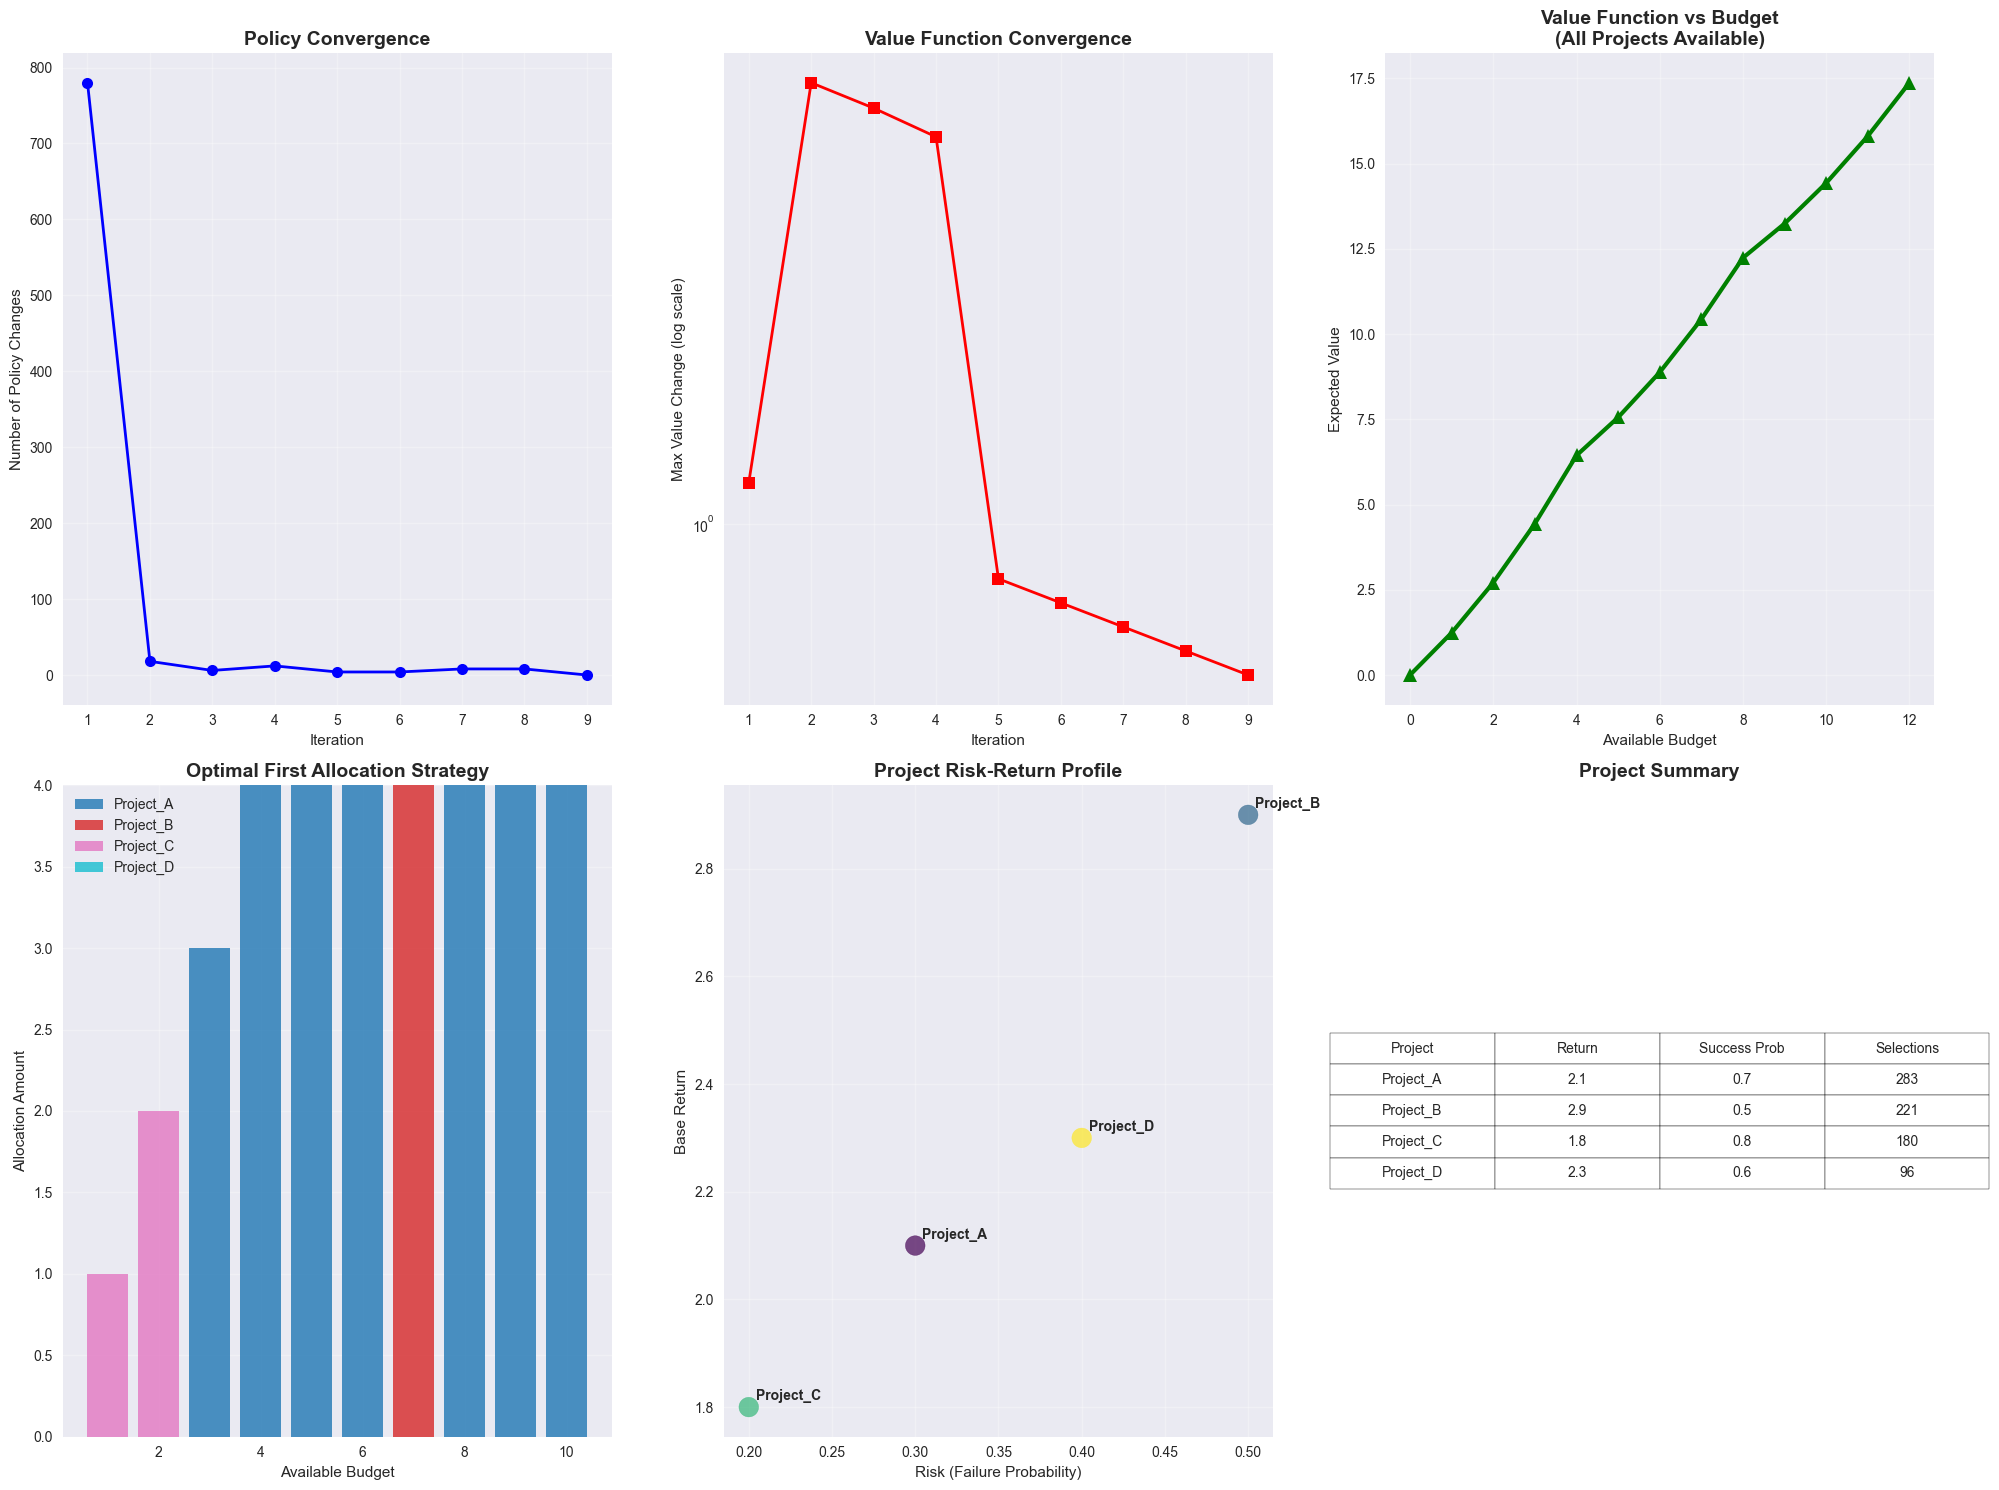


EDUCATIONAL INSIGHTS

Key Learnings from this GPI Implementation:
1. GPI alternates between policy evaluation and improvement until convergence
2. The optimal policy balances risk and return across projects
3. Higher budget allows for more diversified allocation strategies
4. The algorithm finds the globally optimal policy for this stochastic problem
5. Transition probabilities encode the uncertainty in project outcomes

This framework can be extended to more complex resource allocation problems!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Callable
from dataclasses import dataclass
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

@dataclass
class ResourceAllocationMDP:
    """
    Resource Allocation Markov Decision Process
    
    This represents a company that needs to allocate limited resources (budget)
    across different projects. Each project has different success probabilities
    and returns based on the amount of resources allocated.
    """
    n_projects: int = 4          # Number of projects to choose from
    max_budget: int = 10         # Total budget available
    max_allocation: int = 5      # Maximum allocation per project
    discount_factor: float = 0.9 # Discount factor for future rewards
    
    def __post_init__(self):
        # Define project characteristics
        self.project_names = [f"Project_{chr(65+i)}" for i in range(self.n_projects)]
        
        # Each project has different risk-return profiles
        self.project_params = {
            0: {"base_return": 2.1, "volatility": 0.3, "success_prob": 0.7},  # Low risk, medium return
            1: {"base_return": 2.9, "volatility": 0.5, "success_prob": 0.5},  # High risk, high return
            2: {"base_return": 1.8, "volatility": 0.2, "success_prob": 0.8},  # Very low risk, low return
            3: {"base_return": 2.3, "volatility": 0.4, "success_prob": 0.6},  # Medium risk, good return
        }

def create_state_space(mdp: ResourceAllocationMDP) -> List[Tuple]:
    """
    Create the state space for the MDP.
    
    State: (remaining_budget, project_states)
    project_states: tuple indicating the success/failure state of each project
    0 = not started, 1 = successful, -1 = failed
    
    Args:
        mdp: The MDP configuration
    
    Returns:
        List of all possible states
    """
    states = []
    
    # Generate all possible combinations of remaining budget and project outcomes
    for budget in range(mdp.max_budget + 1):
        # For simplicity, we'll consider states where projects are either:
        # not started (0), successful (1), or failed (-1)
        for proj_state in range(3**mdp.n_projects):
            # Convert to base-3 representation for project states
            proj_outcomes = []
            temp = proj_state
            for _ in range(mdp.n_projects):
                proj_outcomes.append(temp % 3 - 1)  # Maps 0,1,2 to -1,0,1
                temp //= 3
            
            states.append((budget, tuple(proj_outcomes)))
    
    return states

def create_action_space(mdp: ResourceAllocationMDP) -> List[Tuple]:
    """
    Create the action space for the MDP.
    
    Action: (project_id, allocation_amount)
    Special action: (-1, 0) represents "do nothing" (end allocation)
    
    Args:
        mdp: The MDP configuration
    
    Returns:
        List of all possible actions
    """
    actions = [(-1, 0)]  # Do nothing action
    
    for project_id in range(mdp.n_projects):
        for allocation in range(1, min(mdp.max_allocation + 1, mdp.max_budget + 1)):
            actions.append((project_id, allocation))
    
    return actions

def transition_probability(mdp: ResourceAllocationMDP, 
                         state: Tuple, 
                         action: Tuple, 
                         next_state: Tuple) -> float:
    """
    Calculate the transition probability P(s'|s,a).
    
    This function defines the stochastic nature of our resource allocation:
    - When we allocate resources to a project, it has a chance of success/failure
    - Success probability depends on the project type and allocation amount
    
    Args:
        mdp: The MDP configuration
        state: Current state (budget, project_outcomes)
        action: Action taken (project_id, allocation)
        next_state: Next state to transition to
    
    Returns:
        Probability of transitioning from state to next_state given action
    """
    budget, proj_outcomes = state
    next_budget, next_proj_outcomes = next_state
    project_id, allocation = action
    
    # Do nothing action
    if project_id == -1:
        return 1.0 if state == next_state else 0.0
    
    # Check if action is valid
    if allocation > budget or allocation <= 0:
        return 0.0
    
    # Check if project is already completed
    if proj_outcomes[project_id] != 0:
        return 0.0
    
    # Check if budget transition is correct
    if next_budget != budget - allocation:
        return 0.0
    
    # Calculate success probability based on allocation
    base_prob = mdp.project_params[project_id]["success_prob"]
    # More allocation increases success probability (with diminishing returns)
    enhanced_prob = min(0.95, base_prob + (allocation - 1) * 0.05)
    
    # Check project outcome transition
    expected_outcomes = list(proj_outcomes)
    
    # Success case
    if next_proj_outcomes[project_id] == 1:
        expected_outcomes[project_id] = 1
        if tuple(expected_outcomes) == next_proj_outcomes:
            return enhanced_prob
    
    # Failure case
    elif next_proj_outcomes[project_id] == -1:
        expected_outcomes[project_id] = -1
        if tuple(expected_outcomes) == next_proj_outcomes:
            return 1.0 - enhanced_prob
    
    return 0.0

def reward_function(mdp: ResourceAllocationMDP, 
                   state: Tuple, 
                   action: Tuple, 
                   next_state: Tuple) -> float:
    """
    Calculate the immediate reward R(s,a,s').
    
    Rewards are given based on:
    - Successful project completion (positive reward)
    - Failed project completion (negative penalty)
    - Resource allocation cost (small negative cost)
    
    Args:
        mdp: The MDP configuration
        state: Current state
        action: Action taken
        next_state: Next state
    
    Returns:
        Immediate reward
    """
    budget, proj_outcomes = state
    next_budget, next_proj_outcomes = next_state
    project_id, allocation = action
    
    reward = 0.0
    
    # Do nothing action - small penalty for inaction if budget remains
    if project_id == -1:
        return -0.1 * budget  # Penalty for unused budget
    
    # Small cost for resource allocation
    reward -= allocation * 0.1
    
    # Check for project completion rewards
    for i in range(mdp.n_projects):
        if proj_outcomes[i] == 0 and next_proj_outcomes[i] != 0:
            if next_proj_outcomes[i] == 1:  # Success
                # Reward based on project's expected return and allocation
                base_return = mdp.project_params[i]["base_return"]
                reward += base_return * allocation
            else:  # Failure
                # Penalty for project failure
                reward -= allocation * 0.5
    
    return reward

def policy_evaluation(mdp: ResourceAllocationMDP, 
                     states: List[Tuple], 
                     policy: Dict[Tuple, Tuple], 
                     value_function: Dict[Tuple, float],
                     theta: float = 1e-6) -> Dict[Tuple, float]:
    """
    Policy Evaluation: Calculate V^π(s) for all states under current policy.
    
    This implements the iterative policy evaluation algorithm:
    V(s) ← Σ_a π(a|s) Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')]
    
    Args:
        mdp: The MDP configuration
        states: List of all states
        policy: Current policy π(s) → a
        value_function: Current value function estimate
        theta: Convergence threshold
    
    Returns:
        Updated value function
    """
    actions = create_action_space(mdp)
    
    iteration = 0
    while True:
        delta = 0.0
        new_value_function = value_function.copy()
        
        for state in states:
            old_value = value_function[state]
            
            # Get action from policy
            action = policy.get(state, (-1, 0))  # Default to do nothing
            
            # Calculate expected value under current policy
            expected_value = 0.0
            for next_state in states:
                trans_prob = transition_probability(mdp, state, action, next_state)
                if trans_prob > 0:
                    reward = reward_function(mdp, state, action, next_state)
                    expected_value += trans_prob * (reward + mdp.discount_factor * value_function[next_state])
            
            new_value_function[state] = expected_value
            delta = max(delta, abs(old_value - expected_value))
        
        value_function = new_value_function
        iteration += 1
        
        if delta < theta:
            break
    
    print(f"Policy evaluation converged in {iteration} iterations")
    return value_function

def policy_improvement(mdp: ResourceAllocationMDP, 
                      states: List[Tuple], 
                      value_function: Dict[Tuple, float]) -> Tuple[Dict[Tuple, Tuple], bool]:
    """
    Policy Improvement: Find better policy using current value function.
    
    This implements the policy improvement step:
    π'(s) = argmax_a Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')]
    
    Args:
        mdp: The MDP configuration
        states: List of all states
        value_function: Current value function
    
    Returns:
        Tuple of (new_policy, policy_stable)
    """
    actions = create_action_space(mdp)
    new_policy = {}
    policy_stable = True
    
    for state in states:
        budget, proj_outcomes = state
        
        # Find valid actions for this state
        valid_actions = []
        for action in actions:
            project_id, allocation = action
            
            # Check if action is valid
            if project_id == -1:  # Do nothing action
                valid_actions.append(action)
            elif (allocation <= budget and 
                  project_id < mdp.n_projects and 
                  proj_outcomes[project_id] == 0):  # Project not completed
                valid_actions.append(action)
        
        # Find best action
        best_action = None
        best_value = float('-inf')
        
        for action in valid_actions:
            expected_value = 0.0
            for next_state in states:
                trans_prob = transition_probability(mdp, state, action, next_state)
                if trans_prob > 0:
                    reward = reward_function(mdp, state, action, next_state)
                    expected_value += trans_prob * (reward + mdp.discount_factor * value_function[next_state])
            
            if expected_value > best_value:
                best_value = expected_value
                best_action = action
        
        new_policy[state] = best_action if best_action else (-1, 0)
    
    return new_policy, policy_stable

def generalized_policy_iteration(mdp: ResourceAllocationMDP, 
                               max_iterations: int = 100) -> Tuple[Dict, Dict, List]:
    """
    Main GPI Algorithm: Alternates between single sweeps of policy evaluation 
    and policy improvement.
    
    The algorithm continues until the policy converges. This is also known as
    Value Iteration, a specific instance of GPI.
    
    Args:
        mdp: The MDP configuration
        max_iterations: Maximum number of GPI iterations
    
    Returns:
        Tuple of (final_policy, final_value_function, convergence_history)
    """
    print("Starting Generalized Policy Iteration...")
    print("=" * 50)
    
    # Initialize state and action spaces
    states = create_state_space(mdp)
    actions = create_action_space(mdp)
    print(f"State space size: {len(states)}")
    
    # Initialize value function and policy
    value_function = {state: 0.0 for state in states}
    policy = {state: (-1, 0) for state in states}  # Start with "do nothing" policy
    
    convergence_history = []
    
    for iteration in range(max_iterations):
        print(f"\nIteration {iteration + 1}:")
        print("-" * 30)
        
        # --- Policy Evaluation (One Sweep) ---
        # We perform one sweep of evaluation (like in Value Iteration)
        old_value_function = value_function.copy()
        delta = 0.0
        
        for state in states:
            # Get action from the current policy to evaluate
            action = policy.get(state, (-1, 0))
            
            # Calculate expected value for the action defined by the policy
            expected_value = 0.0
            for next_state in states:
                trans_prob = transition_probability(mdp, state, action, next_state)
                if trans_prob > 0:
                    reward = reward_function(mdp, state, action, next_state)
                    # Bellman update using the value function from the *previous* iteration
                    expected_value += trans_prob * (reward + mdp.discount_factor * old_value_function[next_state])
            
            value_function[state] = expected_value
            delta = max(delta, abs(old_value_function[state] - value_function[state]))
            
        print(f"Policy evaluation sweep complete. Max value change: {delta:.6f}")

        # --- Policy Improvement (One Sweep) ---
        # Greedily update the policy based on the new value function
        policy_stable = True
        old_policy = policy.copy()

        for state in states:
            budget, proj_outcomes = state
            
            # Find valid actions for this state
            valid_actions = []
            for action in actions:
                project_id, allocation = action
                if project_id == -1:  # Do nothing action
                    valid_actions.append(action)
                elif (allocation <= budget and 
                      project_id < mdp.n_projects and 
                      proj_outcomes[project_id] == 0):  # Project not completed
                    valid_actions.append(action)
            
            # Find the best action by looking one step ahead
            best_action = None
            best_value = float('-inf')
            
            for action in valid_actions:
                # Calculate the Q-value for this state-action pair
                action_value = 0.0
                for next_state in states:
                    trans_prob = transition_probability(mdp, state, action, next_state)
                    if trans_prob > 0:
                        reward = reward_function(mdp, state, action, next_state)
                        # Use the just-updated value function
                        action_value += trans_prob * (reward + mdp.discount_factor * value_function[next_state])
                
                if action_value > best_value:
                    best_value = action_value
                    best_action = action
            
            policy[state] = best_action if best_action else (-1, 0)
            
            # Check if the policy has changed for this state
            if old_policy.get(state) != policy[state]:
                policy_stable = False
        
        policy_changed = sum(1 for s in states if old_policy.get(s) != policy.get(s))
        print(f"Policy improvement sweep complete. Policy changes: {policy_changed}")

        # Record convergence metrics
        convergence_history.append({
            'iteration': iteration + 1,
            'policy_changes': policy_changed,
            'max_value_change': delta
        })
        
        # Check for convergence
        if policy_stable:
            print(f"\nPolicy converged after {iteration + 1} iterations!")
            break
            
    return policy, value_function, convergence_history

def analyze_optimal_policy(mdp: ResourceAllocationMDP, 
                          policy: Dict[Tuple, Tuple], 
                          value_function: Dict[Tuple, float]) -> None:
    """
    Analyze and display insights from the optimal policy.
    
    Args:
        mdp: The MDP configuration
        policy: Optimal policy
        value_function: Optimal value function
    """
    print("\n" + "="*60)
    print("OPTIMAL POLICY ANALYSIS")
    print("="*60)
    
    # Analyze initial state decisions
    initial_states = [(budget, tuple([0]*mdp.n_projects)) for budget in range(1, mdp.max_budget + 1)]
    
    print("\nOptimal first moves for different budget levels:")
    print("-" * 50)
    
    for budget in range(1, min(mdp.max_budget + 1, 11)):  # Show first 10 budget levels
        state = (budget, tuple([0]*mdp.n_projects))
        if state in policy:
            action = policy[state]
            value = value_function[state]
            
            if action[0] == -1:
                print(f"Budget {budget:2d}: Do nothing (Value: {value:.2f})")
            else:
                proj_name = mdp.project_names[action[0]]
                print(f"Budget {budget:2d}: Allocate {action[1]} to {proj_name} (Value: {value:.2f})")
    
    # Project preference analysis
    print("\nProject allocation frequency in optimal policy:")
    print("-" * 50)
    
    project_counts = {i: 0 for i in range(mdp.n_projects)}
    total_decisions = 0
    
    for state, action in policy.items():
        if action[0] != -1:  # Not "do nothing"
            project_counts[action[0]] += 1
        total_decisions += 1
    
    for i, count in project_counts.items():
        percentage = (count / total_decisions) * 100
        proj_name = mdp.project_names[i]
        params = mdp.project_params[i]
        print(f"{proj_name}: {count:3d} times ({percentage:5.1f}%) - "
              f"Return: {params['base_return']:.1f}, Success: {params['success_prob']:.1f}")

def visualize_results(mdp: ResourceAllocationMDP, 
                     policy: Dict[Tuple, Tuple], 
                     value_function: Dict[Tuple, float], 
                     convergence_history: List[Dict]) -> None:
    """
    Create comprehensive visualizations of the GPI results.
    
    Args:
        mdp: The MDP configuration
        policy: Optimal policy
        value_function: Optimal value function
        convergence_history: History of convergence
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Convergence History
    ax1 = plt.subplot(2, 3, 1)
    iterations = [h['iteration'] for h in convergence_history]
    policy_changes = [h['policy_changes'] for h in convergence_history]
    
    plt.plot(iterations, policy_changes, 'b-o', linewidth=2, markersize=8)
    plt.title('Policy Convergence', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Policy Changes')
    plt.grid(True, alpha=0.3)
    
    # 2. Value Function Convergence
    ax2 = plt.subplot(2, 3, 2)
    value_changes = [h['max_value_change'] for h in convergence_history]
    
    plt.semilogy(iterations, value_changes, 'r-s', linewidth=2, markersize=8)
    plt.title('Value Function Convergence', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Max Value Change (log scale)')
    plt.grid(True, alpha=0.3)
    
    # 3. Value Function Heatmap (for different budget levels)
    ax3 = plt.subplot(2, 3, 3)
    budget_levels = list(range(mdp.max_budget + 1))
    value_matrix = []
    
    for budget in budget_levels:
        state = (budget, tuple([0] * mdp.n_projects))
        if state in value_function:
            value_matrix.append(value_function[state])
        else:
            value_matrix.append(0)
    
    # Create a simple heatmap
    plt.plot(budget_levels, value_matrix, 'g-^', linewidth=3, markersize=10)
    plt.title('Value Function vs Budget\n(All Projects Available)', fontsize=14, fontweight='bold')
    plt.xlabel('Available Budget')
    plt.ylabel('Expected Value')
    plt.grid(True, alpha=0.3)
    
    # 4. Project Allocation Strategy
    ax4 = plt.subplot(2, 3, 4)
    project_allocations = {i: [] for i in range(mdp.n_projects)}
    budgets = []
    
    for budget in range(1, min(mdp.max_budget + 1, 11)):
        state = (budget, tuple([0] * mdp.n_projects))
        if state in policy:
            action = policy[state]
            budgets.append(budget)
            for i in range(mdp.n_projects):
                if action[0] == i:
                    project_allocations[i].append(action[1])
                else:
                    project_allocations[i].append(0)
    
    # Stacked bar chart
    bottom = np.zeros(len(budgets))
    #colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"][:mdp.n_projects]
    colors = plt.cm.tab10(np.linspace(0, 1, mdp.n_projects))


 

 
 
    
    for i in range(mdp.n_projects):
        plt.bar(budgets, project_allocations[i], bottom=bottom, 
               label=mdp.project_names[i], color=colors[i], alpha=0.8)
        bottom = np.array(bottom) + np.array(project_allocations[i])
    
    plt.title('Optimal First Allocation Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Available Budget')
    plt.ylabel('Allocation Amount')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Project Risk-Return Profile
    ax5 = plt.subplot(2, 3, 5)
    returns = [mdp.project_params[i]['base_return'] for i in range(mdp.n_projects)]
    risks = [1 - mdp.project_params[i]['success_prob'] for i in range(mdp.n_projects)]
    
    scatter = plt.scatter(risks, returns, s=200, alpha=0.7, c=range(mdp.n_projects), cmap='viridis')
    
    for i in range(mdp.n_projects):
        plt.annotate(mdp.project_names[i], (risks[i], returns[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    plt.title('Project Risk-Return Profile', fontsize=14, fontweight='bold')
    plt.xlabel('Risk (Failure Probability)')
    plt.ylabel('Base Return')
    plt.grid(True, alpha=0.3)
    
    # 6. Policy Performance Summary
    ax6 = plt.subplot(2, 3, 6)
    
    # Create a summary table
    summary_data = []
    for i in range(mdp.n_projects):
        params = mdp.project_params[i]
        # Count how often this project is selected
        selection_count = sum(1 for action in policy.values() if action[0] == i)
        
        summary_data.append([
            mdp.project_names[i],
            f"{params['base_return']:.1f}",
            f"{params['success_prob']:.1f}",
            f"{selection_count}"
        ])
    
    # Create table
    table = plt.table(cellText=summary_data,
                     colLabels=['Project', 'Return', 'Success Prob', 'Selections'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    plt.title('Project Summary', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def simulate_policy_execution(mdp: ResourceAllocationMDP, 
                            policy: Dict[Tuple, Tuple], 
                            initial_budget: int = 10, 
                            num_simulations: int = 1000) -> Dict:
    """
    Simulate the execution of the optimal policy to show real performance.
    
    Args:
        mdp: The MDP configuration
        policy: The optimal policy to simulate
        initial_budget: Starting budget for simulation
        num_simulations: Number of simulation runs
    
    Returns:
        Dictionary with simulation results and statistics
    """
    print("\n" + "="*60)
    print("POLICY SIMULATION RESULTS")
    print("="*60)
    
    total_rewards = []
    project_success_counts = {i: 0 for i in range(mdp.n_projects)}
    project_attempt_counts = {i: 0 for i in range(mdp.n_projects)}
    
    for sim in range(num_simulations):
        current_state = (initial_budget, tuple([0] * mdp.n_projects))
        total_reward = 0.0
        steps = 0
        
        while steps < 20:  # Prevent infinite loops
            if current_state not in policy:
                break
                
            action = policy[current_state]
            project_id, allocation = action
            
            # Do nothing action - end simulation
            if project_id == -1:
                break
            
            # Record attempt
            project_attempt_counts[project_id] += 1
            
            # Simulate project outcome
            budget, proj_outcomes = current_state
            success_prob = mdp.project_params[project_id]["success_prob"]
            enhanced_prob = min(0.95, success_prob + (allocation - 1) * 0.05)
            
            # Determine outcome
            if np.random.random() < enhanced_prob:
                # Success
                new_proj_outcomes = list(proj_outcomes)
                new_proj_outcomes[project_id] = 1
                reward = mdp.project_params[project_id]["base_return"] * allocation - allocation * 0.1
                project_success_counts[project_id] += 1
            else:
                # Failure
                new_proj_outcomes = list(proj_outcomes)
                new_proj_outcomes[project_id] = -1
                reward = -allocation * 0.5 - allocation * 0.1
            
            total_reward += reward
            current_state = (budget - allocation, tuple(new_proj_outcomes))
            steps += 1
        
        total_rewards.append(total_reward)
    
    # Calculate statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    
    print(f"Average reward over {num_simulations} simulations: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Best performance: {max(total_rewards):.2f}")
    print(f"Worst performance: {min(total_rewards):.2f}")
    
    print("\nProject Performance:")
    print("-" * 30)
    for i in range(mdp.n_projects):
        attempts = project_attempt_counts[i]
        successes = project_success_counts[i]
        if attempts > 0:
            success_rate = successes / attempts
            print(f"{mdp.project_names[i]}: {successes}/{attempts} successes ({success_rate:.1%})")
        else:
            print(f"{mdp.project_names[i]}: Never attempted")
    
    return {
        'rewards': total_rewards,
        'avg_reward': avg_reward,
        'std_reward': std_reward,
        'project_success_counts': project_success_counts,
        'project_attempt_counts': project_attempt_counts
    }

def main():
    """
    Main function to demonstrate the complete GPI algorithm on resource allocation.
    """
    print("RESOURCE ALLOCATION WITH GENERALIZED POLICY ITERATION")
    print("=" * 80)
    print()
    print("This example demonstrates optimal resource allocation across multiple projects")
    print("using dynamic programming and the GPI algorithm.")
    print()
    
    # Create MDP instance
    mdp = ResourceAllocationMDP(
        n_projects=4,
        max_budget=12,  # Smaller for faster computation
        max_allocation=4,
        discount_factor=0.9
    )
    
    print("MDP Configuration:")
    print(f"- Number of projects: {mdp.n_projects}")
    print(f"- Maximum budget: {mdp.max_budget}")
    print(f"- Maximum allocation per project: {mdp.max_allocation}")
    print(f"- Discount factor: {mdp.discount_factor}")
    print()
    
    print("Project Characteristics:")
    for i, params in mdp.project_params.items():
        print(f"- {mdp.project_names[i]}: Return={params['base_return']:.1f}, "
              f"Success Prob={params['success_prob']:.1f}")
    print()
    
    # Run GPI algorithm
    optimal_policy, optimal_value_function, convergence_history = generalized_policy_iteration(mdp)
    
    # Analyze results
    analyze_optimal_policy(mdp, optimal_policy, optimal_value_function)
    
    # Simulate policy performance
    simulation_results = simulate_policy_execution(mdp, optimal_policy, initial_budget=mdp.max_budget)
    
    # Create visualizations
    visualize_results(mdp, optimal_policy, optimal_value_function, convergence_history)
    
    print("\n" + "="*80)
    print("EDUCATIONAL INSIGHTS")
    print("="*80)
    print()
    print("Key Learnings from this GPI Implementation:")
    print("1. GPI alternates between policy evaluation and improvement until convergence")
    print("2. The optimal policy balances risk and return across projects")
    print("3. Higher budget allows for more diversified allocation strategies")
    print("4. The algorithm finds the globally optimal policy for this stochastic problem")
    print("5. Transition probabilities encode the uncertainty in project outcomes")
    print()
    print("This framework can be extended to more complex resource allocation problems!")

if __name__ == "__main__":
    main()